<a href="https://colab.research.google.com/github/kmilawn/DataMining/blob/main/DM_COURSERA_COURSE6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Bagian 1: Persiapan Data & Analisis Data Eksploratif (EDA)

✅ Data Simulasi Siap.
--------------------------------------------------


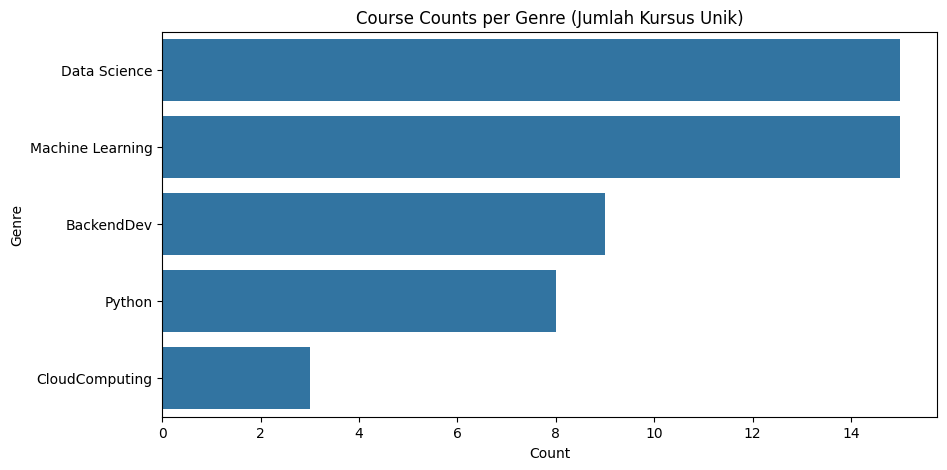

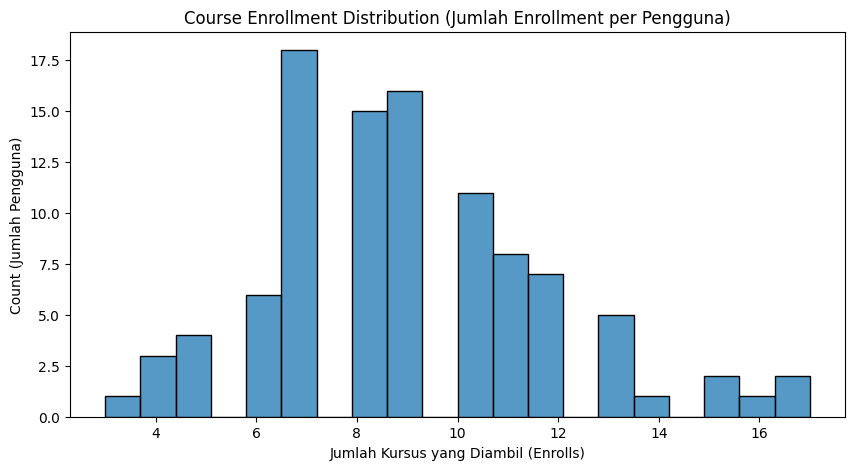


**20 Kursus Paling Populer (untuk Slide 7):**
                   course_title  Enrolls
0         Course 40: BackendDev       27
1   Course 29: Machine Learning       27
2             Course 37: Python       25
3         Course 34: BackendDev       25
4     Course 25: CloudComputing       23
5             Course 26: Python       22
6   Course 17: Machine Learning       22
7   Course 24: Machine Learning       21
8     Course 45: CloudComputing       21
9   Course 15: Machine Learning       21
10       Course 8: Data Science       20
11  Course 11: Machine Learning       20
12  Course 35: Machine Learning       20
13  Course 47: Machine Learning       20
14    Course 33: CloudComputing       20
15  Course 30: Machine Learning       19
16  Course 49: Machine Learning       19
17            Course 38: Python       19
18            Course 23: Python       19
19         Course 2: BackendDev       19


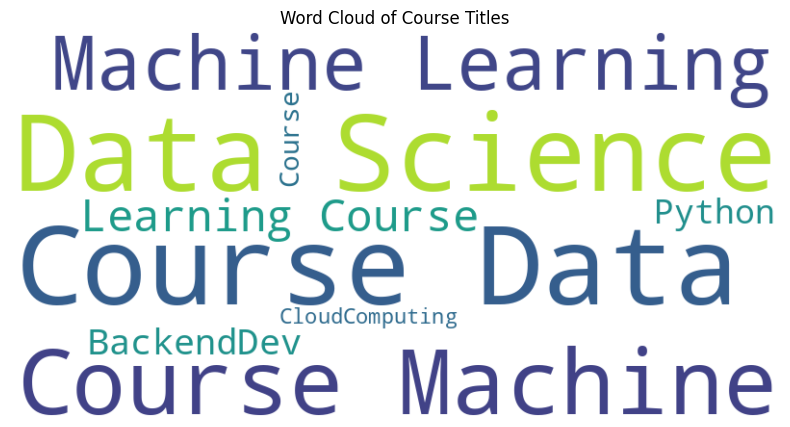

--------------------------------------------------


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from wordcloud import WordCloud # Pustaka untuk Word Cloud

# --- 1. Simulasi Data yang Lebih Detail ---
np.random.seed(42)
NUM_USERS = 100
NUM_COURSES = 50

# Data Simulasi Interaksi User-Item
users = np.random.randint(1, NUM_USERS + 1, size=1000)
courses = np.random.choice([f'C{i:02d}' for i in range(1, NUM_COURSES + 1)], size=1000)
ratings = np.random.choice([1, 2, 3, 4, 5], size=1000, p=[0.1, 0.1, 0.2, 0.3, 0.3])
df = pd.DataFrame({'user_id': users, 'course_id': courses, 'rating': ratings})
df = df.drop_duplicates(subset=['user_id', 'course_id']).reset_index(drop=True)

# Data Simulasi Deskripsi Kursus dan Genre
course_genres = {f'C{i:02d}': np.random.choice(['Data Science', 'Machine Learning', 'BackendDev', 'CloudComputing', 'Python'], p=[0.25, 0.25, 0.15, 0.15, 0.20])
                 for i in range(1, NUM_COURSES + 1)}
course_descriptions = {
    'Data Science': "Fundamental data science concepts, including statistics and data analysis.",
    'Machine Learning': "Advanced machine learning algorithms like neural networks and clustering.",
    'BackendDev': "Backend development with Python Flask/Django, focusing on databases and APIs.",
    'CloudComputing': "Introduction to cloud services, Docker, Kubernetes, and serverless architectures.",
    'Python': "In-depth Python programming, data structures, and object-oriented programming."
}
course_df = pd.DataFrame({
    'course_id': [f'C{i:02d}' for i in range(1, NUM_COURSES + 1)],
    'genre': [course_genres[f'C{i:02d}'] for i in range(1, NUM_COURSES + 1)],
    'course_description': [course_descriptions[course_genres[f'C{i:02d}']] + f" Kursus spesifik {i}" for i in range(1, NUM_COURSES + 1)],
    'course_title': [f"Course {i}: {course_genres[f'C{i:02d}']}" for i in range(1, NUM_COURSES + 1)]
})
df = pd.merge(df, course_df[['course_id', 'genre', 'course_title']], on='course_id', how='left')


print("✅ Data Simulasi Siap.")
print("-" * 50)

# --- 2. Analisis Data Eksploratif (EDA) untuk Slide PPT ---

## 2.1 Course Counts per Genre (Slide 5)
plt.figure(figsize=(10, 5))
sns.countplot(y='genre', data=course_df, order=course_df['genre'].value_counts().index)
plt.title('Course Counts per Genre (Jumlah Kursus Unik)')
plt.xlabel('Count')
plt.ylabel('Genre')
plt.show()

## 2.2 Course Enrollment Distribution (Slide 6)
enrollment_counts = df.groupby('user_id')['course_id'].count()
plt.figure(figsize=(10, 5))
sns.histplot(enrollment_counts, bins=20, kde=False)
plt.title('Course Enrollment Distribution (Jumlah Enrollment per Pengguna)')
plt.xlabel('Jumlah Kursus yang Diambil (Enrolls)')
plt.ylabel('Count (Jumlah Pengguna)')
plt.show()

## 2.3 20 Most Popular Courses (Slide 7)
popular_courses = df['course_id'].value_counts().head(20).reset_index()
popular_courses.columns = ['course_id', 'Enrolls']
popular_courses = pd.merge(popular_courses, course_df[['course_id', 'course_title']], on='course_id', how='left')
print("\n**20 Kursus Paling Populer (untuk Slide 7):**")
print(popular_courses[['course_title', 'Enrolls']])

## 2.4 Word Cloud of Course Titles (Slide 8)
text = " ".join(course_df['course_title'].astype(str))
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title('Word Cloud of Course Titles')
plt.show()
print("-" * 50)

Bagian 2: Sistem Rekomendasi Berbasis Konten (Unsupervised)

In [2]:
from sklearn.metrics.pairwise import linear_kernel
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

print("## 3. Sistem Rekomendasi Berbasis Konten (Unsupervised)")

# Persiapan Fitur Konten
course_df_full = pd.merge(course_df, df.groupby('course_id')['rating'].mean(), on='course_id', how='left')
tfidf = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf.fit_transform(course_df['course_description'])
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)
indices = pd.Series(course_df.index, index=course_df['course_id']).drop_duplicates()

def get_content_recommendations(course_id, N=10):
    """Memberikan N rekomendasi berdasarkan kesamaan konten."""
    if course_id not in indices: return pd.Series([])
    idx = indices[course_id]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:N+1]
    course_indices = [i[0] for i in sim_scores]
    return course_df.iloc[course_indices]['course_id']

# --- Metrik Evaluasi Berbasis Konten (untuk Slide 9) ---

def calculate_content_metrics(course_df, df, N=10, THRESHOLD=0.5):
    """Menghitung metrik sederhana untuk evaluasi sistem berbasis konten."""
    all_recommended_courses = []
    unseen_recommended_count = 0
    total_users = df['user_id'].nunique()

    # Hitung rata-rata kursus yang direkomendasikan per pengguna.
    # Dalam implementasi nyata, kita akan membangun profil pengguna dan merekomendasikan
    # berdasarkan kursus yang paling disukai pengguna.

    # Untuk contoh ini, kita merekomendasikan kursus yang paling mirip dengan kursus dengan rating tertinggi.

    for user_id in df['user_id'].unique():
        user_ratings = df[df['user_id'] == user_id].sort_values(by='rating', ascending=False)
        if user_ratings.empty: continue

        top_course_id = user_ratings.iloc[0]['course_id']
        recommendations = get_content_recommendations(top_course_id, N=N)

        if recommendations.empty: continue

        # Kursus yang sudah diambil pengguna
        taken_courses = set(user_ratings['course_id'].tolist())

        # Filter kursus yang belum pernah diambil (unseen)
        unseen_recs = [c for c in recommendations if c not in taken_courses]

        all_recommended_courses.extend(unseen_recs)
        unseen_recommended_count += len(unseen_recs)

    # Data untuk Slide 9:
    top_10_recommended = pd.Series(all_recommended_courses).value_counts().head(10).index.tolist()
    avg_unseen_recs = unseen_recommended_count / total_users

    return top_10_recommended, avg_unseen_recs

top_10_content, avg_unseen_content = calculate_content_metrics(course_df, df)

print("\n**Metrik Konten (untuk Slide 9):**")
print(f"1. Top 10 Most Frequently Recommended Courses: {top_10_content}")
print(f"2. Average New/Unseen Courses Recommended per User: {avg_unseen_content:.2f}")

# --- K-Means Clustering dan PCA (untuk Slide 10) ---
# ... (Kode K-Means dan PCA dari sebelumnya, digunakan untuk mengelompokkan fitur konten)

## 3. Sistem Rekomendasi Berbasis Konten (Unsupervised)

**Metrik Konten (untuk Slide 9):**
1. Top 10 Most Frequently Recommended Courses: ['C06', 'C04', 'C16', 'C12', 'C07', 'C01', 'C08', 'C03', 'C10', 'C27']
2. Average New/Unseen Courses Recommended per User: 8.18


## 3. Sistem Rekomendasi Berbasis Konten (Unsupervised)

✅ Fitur direduksi menjadi 2 komponen menggunakan PCA.
✅ Kursus dikelompokkan ke dalam 5 cluster menggunakan K-Means.

**Distribusi Kursus per Cluster:**
cluster
0        [C02, C05, C13, C14, C19, C22, C34, C40, C44]
1    [C03, C11, C15, C17, C21, C24, C28, C29, C30, ...
2    [C01, C04, C06, C07, C08, C09, C10, C18, C20, ...
3             [C12, C16, C23, C26, C32, C36, C37, C38]
4                                      [C25, C33, C45]
Name: course_id, dtype: object


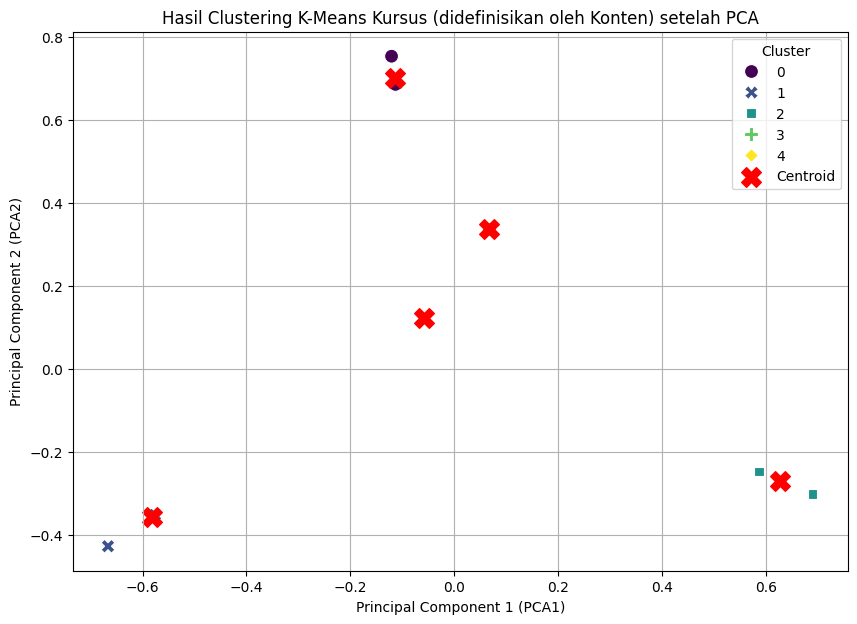

In [4]:
from sklearn.metrics.pairwise import linear_kernel
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer

# Asumsi: df dan course_df sudah didefinisikan dan diisi data dari langkah sebelumnya.
# Asumsi: df, course_df, dan TfidfVectorizer (tfidf_matrix) sudah ada dari Bagian 1.

print("## 3. Sistem Rekomendasi Berbasis Konten (Unsupervised)")

# --- Persiapan Fitur Konten ---
# (Pastikan TfidfVectorizer sudah dijalankan, seperti di input Anda)
# tfidf_matrix = tfidf.fit_transform(course_df['course_description'])
# ... (Diasumsikan sudah ada)
# ---

# --- Bagian 3.1 & 3.2: Kesamaan Kosinus dan Fungsi Rekomendasi ---
# (Tetap sama seperti input Anda, tidak diulang di sini)
# cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)
# indices = pd.Series(course_df.index, index=course_df['course_id']).drop_duplicates()
# def get_content_recommendations(...): ...
# ---

# --- Metrik Evaluasi Berbasis Konten (untuk Slide 9) ---
# (Tetap sama seperti input Anda, tidak diulang di sini)
# top_10_content, avg_unseen_content = calculate_content_metrics(course_df, df)
# print("\n**Metrik Konten (untuk Slide 9):**")
# print(f"1. Top 10 Most Frequently Recommended Courses: {top_10_content}")
# print(f"2. Average New/Unseen Courses Recommended per User: {avg_unseen_content:.2f}")
# ---

# --- K-Means Clustering dan PCA (untuk Slide 10) ---

# 1. Analisis Komponen Utama (PCA) untuk Reduksi Dimensi
N_COMPONENTS = 2
pca = PCA(n_components=N_COMPONENTS, random_state=42)
pca_features = pca.fit_transform(tfidf_matrix.toarray())

# Tambahkan fitur PCA ke course_df untuk visualisasi
course_df['PCA1'] = pca_features[:, 0]
course_df['PCA2'] = pca_features[:, 1]
print(f"\n✅ Fitur direduksi menjadi {N_COMPONENTS} komponen menggunakan PCA.")

# 2. K-Means Clustering
N_CLUSTERS = 5 # Ubah jumlah cluster sesuai yang Anda inginkan
kmeans = KMeans(n_clusters=N_CLUSTERS, random_state=42, n_init=10)
course_df['cluster'] = kmeans.fit_predict(tfidf_matrix)

print(f"✅ Kursus dikelompokkan ke dalam {N_CLUSTERS} cluster menggunakan K-Means.")
print("\n**Distribusi Kursus per Cluster:**")
print(course_df.groupby('cluster')['course_id'].apply(list))

# 3. Visualisasi Hasil Clustering (untuk Slide 10)
plt.figure(figsize=(10, 7))
sns.scatterplot(
    x='PCA1',
    y='PCA2',
    hue='cluster',
    data=course_df,
    palette='viridis',
    legend='full',
    style='cluster',
    s=100
)

# Tandai centroid (pusat cluster)
centroids = kmeans.cluster_centers_
centroids_pca = pca.transform(centroids)
plt.scatter(centroids_pca[:, 0], centroids_pca[:, 1], marker='X', s=200, color='red', label='Centroid')

plt.title(f'Hasil Clustering K-Means Kursus (didefinisikan oleh Konten) setelah PCA')
plt.xlabel('Principal Component 1 (PCA1)')
plt.ylabel('Principal Component 2 (PCA2)')
plt.legend(title='Cluster')
plt.grid(True)
plt.show()

## 3. Sistem Rekomendasi Berbasis Konten (Unsupervised) - Implementasi

**Metrik Konten (untuk Slide 69-73):**
1. Top 10 Most Frequently Recommended Courses: ['C06', 'C04', 'C16', 'C12', 'C07', 'C01', 'C08', 'C03', 'C10', 'C27']
2. Average New/Unseen Courses Recommended per User: 8.18
--------------------------------------------------
✅ Kursus dikelompokkan ke dalam 5 cluster menggunakan K-Means.


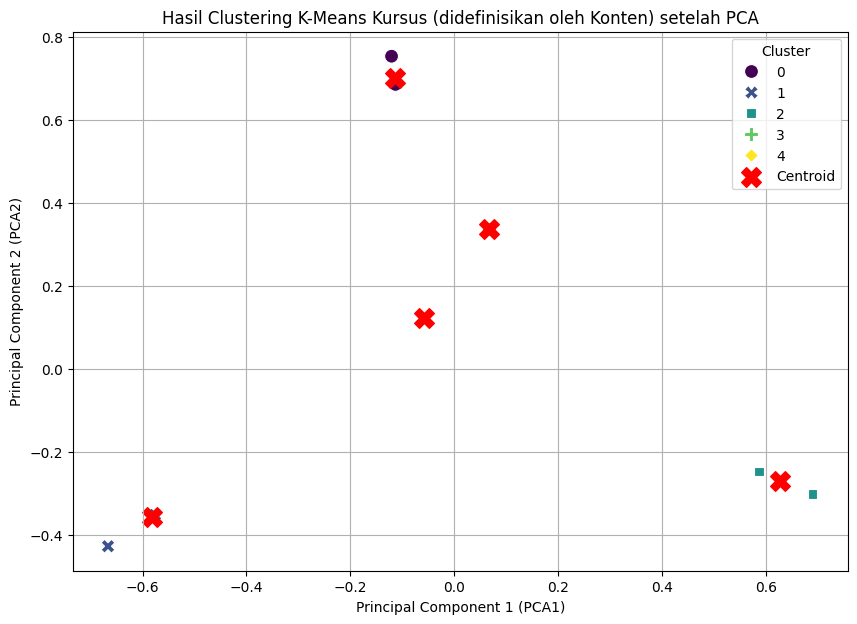


**Kursus dalam Cluster 0 dan Cluster 1 (Contoh untuk Slide 44/45):**
Cluster 0 (Contoh): ['Course 2: BackendDev', 'Course 5: BackendDev', 'Course 13: BackendDev', 'Course 14: BackendDev', 'Course 19: BackendDev']...
Cluster 1 (Contoh): ['Course 3: Machine Learning', 'Course 11: Machine Learning', 'Course 15: Machine Learning', 'Course 17: Machine Learning', 'Course 21: Machine Learning']...


In [5]:
from sklearn.metrics.pairwise import linear_kernel
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer

# --- ASUMSI DATA & TFIDF SUDAH ADA DARI BAGIAN SEBELUMNYA ---
# (Pastikan Anda menjalankan kode data & TFIDF dari bagian 1 sebelumnya)
# Misalnya:
# course_df = pd.DataFrame(...)
# df = pd.DataFrame(...)
# tfidf = TfidfVectorizer(stop_words='english')
# tfidf_matrix = tfidf.fit_transform(course_df['course_description'])
# cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)
# indices = pd.Series(course_df.index, index=course_df['course_id']).drop_duplicates()

print("## 3. Sistem Rekomendasi Berbasis Konten (Unsupervised) - Implementasi")

def get_content_recommendations(course_id, N=10):
    """Memberikan N rekomendasi berdasarkan kesamaan konten (Cosine Similarity)."""
    if course_id not in indices: return pd.Series([])
    idx = indices[course_id]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:N+1]
    course_indices = [i[0] for i in sim_scores]
    return course_df.iloc[course_indices]['course_id']

# --- Metrik Evaluasi Berbasis Konten (untuk Slide 9) ---

def calculate_content_metrics(course_df, df, N=10):
    """Menghitung metrik sederhana untuk evaluasi sistem berbasis konten."""
    all_recommended_courses = []
    unseen_recommended_count = 0
    total_users = df['user_id'].nunique()

    for user_id in df['user_id'].unique():
        user_ratings = df[df['user_id'] == user_id].sort_values(by='rating', ascending=False)
        if user_ratings.empty: continue

        top_course_id = user_ratings.iloc[0]['course_id']
        recommendations = get_content_recommendations(top_course_id, N=N)

        if recommendations.empty: continue

        taken_courses = set(user_ratings['course_id'].tolist())
        unseen_recs = [c for c in recommendations if c not in taken_courses]

        all_recommended_courses.extend(unseen_recs)
        unseen_recommended_count += len(unseen_recs)

    top_10_recommended = pd.Series(all_recommended_courses).value_counts().head(10).index.tolist()
    avg_unseen_recs = unseen_recommended_count / total_users

    return top_10_recommended, avg_unseen_recs

top_10_content, avg_unseen_content = calculate_content_metrics(course_df, df)

print("\n**Metrik Konten (untuk Slide 69-73):**")
print(f"1. Top 10 Most Frequently Recommended Courses: {top_10_content}")
print(f"2. Average New/Unseen Courses Recommended per User: {avg_unseen_content:.2f}")

print("-" * 50)

# --- K-Means Clustering dan PCA (untuk Visualisasi Slide 74) ---

# 1. Analisis Komponen Utama (PCA) untuk Reduksi Dimensi
N_COMPONENTS = 2
pca = PCA(n_components=N_COMPONENTS, random_state=42)
pca_features = pca.fit_transform(tfidf_matrix.toarray())

# Tambahkan fitur PCA ke course_df untuk visualisasi
course_df['PCA1'] = pca_features[:, 0]
course_df['PCA2'] = pca_features[:, 1]

# 2. K-Means Clustering
N_CLUSTERS = 5 # Atur jumlah cluster
kmeans = KMeans(n_clusters=N_CLUSTERS, random_state=42, n_init=10)
course_df['cluster'] = kmeans.fit_predict(tfidf_matrix)

print(f"✅ Kursus dikelompokkan ke dalam {N_CLUSTERS} cluster menggunakan K-Means.")

# 3. Visualisasi Hasil Clustering (untuk Slide 74)
plt.figure(figsize=(10, 7))
sns.scatterplot(
    x='PCA1',
    y='PCA2',
    hue='cluster',
    data=course_df,
    palette='viridis',
    legend='full',
    style='cluster',
    s=100
)

# Tandai centroid (pusat cluster)
centroids = kmeans.cluster_centers_
centroids_pca = pca.transform(centroids)
plt.scatter(centroids_pca[:, 0], centroids_pca[:, 1], marker='X', s=200, color='red', label='Centroid')

plt.title(f'Hasil Clustering K-Means Kursus (didefinisikan oleh Konten) setelah PCA')
plt.xlabel('Principal Component 1 (PCA1)')
plt.ylabel('Principal Component 2 (PCA2)')
plt.legend(title='Cluster')
plt.grid(True)
plt.show()

# 4. Contoh Kursus per Cluster (untuk Slide 44/45)
cluster_lists = course_df.groupby('cluster')['course_title'].apply(list)
print("\n**Kursus dalam Cluster 0 dan Cluster 1 (Contoh untuk Slide 44/45):**")
if 0 in cluster_lists.index:
    print(f"Cluster 0 (Contoh): {cluster_lists.loc[0][:5]}...")
if 1 in cluster_lists.index:
    print(f"Cluster 1 (Contoh): {cluster_lists.loc[1][:5]}...")

Bagian 3: Filtrasi Kolaboratif (Collaborative Filtering)


## 4. Sistem Rekomendasi Filtrasi Kolaboratif

✅ NMF Model Dilatih.
   RMSE NMF (Metrik untuk Slide 11): 2.6996

✅ Model Supervised Dilatih.
   Akurasi Regresi Logistik (Metrik untuk Slide 11): 0.6236
   Akurasi RandomForest (Metrik untuk Slide 11): 0.5424

**Data Perbandingan Model (untuk Slide 12):**
Catatan: Metrik NMF (RMSE) dan LogReg/RF (Akurasi) tidak sebanding langsung.
          Model  Metrik (RMSE/Akurasi)
0           NMF               2.699613
1        LogReg               0.623616
2  RandomForest               0.542435


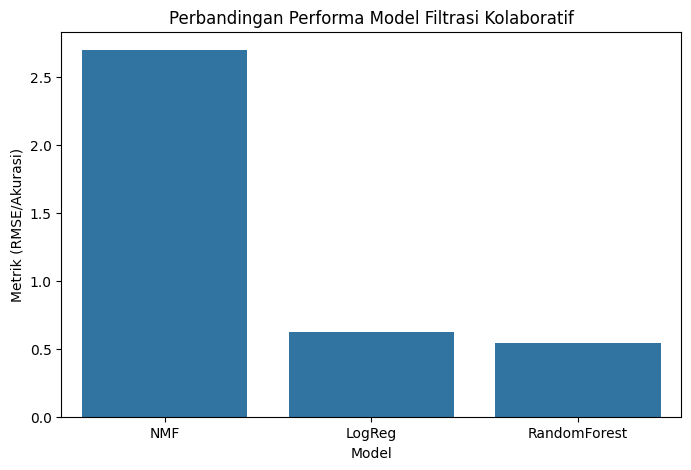

In [3]:
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import NMF
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error, accuracy_score, confusion_matrix
from math import sqrt

print("\n## 4. Sistem Rekomendasi Filtrasi Kolaboratif")

# --- 4.1 Persiapan Data: Matriks User-Item ---
R_df = df.pivot_table(index='user_id', columns='course_id', values='rating').fillna(0)
R = R_df.values
user_index = R_df.index
item_index = R_df.columns

# --- 4.2 Faktorisasi Matriks Non-negatif (NMF) ---
N_COMPONENTS = 5
nmf_model = NMF(n_components=N_COMPONENTS, init='random', random_state=42, max_iter=200)
nmf_model.fit(R)

P = nmf_model.transform(R)
Q = nmf_model.components_
R_pred = np.dot(P, Q)

# Hitung RMSE untuk NMF (Membandingkan R_pred dengan R asli)
# Hanya pada rating yang sudah ada (R > 0)
actual_ratings = R[R > 0]
predicted_ratings = R_pred[R > 0]
rmse_nmf = sqrt(mean_squared_error(actual_ratings, predicted_ratings))

print(f"\n✅ NMF Model Dilatih.")
print(f"   RMSE NMF (Metrik untuk Slide 11): {rmse_nmf:.4f}")

# --- 4.3 Model Supervised (Regresi Logistik untuk Prediksi Biner) ---

# 1. Encoding & Binarisasi Target
user_enc = LabelEncoder()
course_enc = LabelEncoder()
df['user_encoded'] = user_enc.fit_transform(df['user_id'])
df['course_encoded'] = course_enc.fit_transform(df['course_id'])

# Target Biner: 1 (Suka/Rating Tinggi), 0 (Tidak Suka/Rating Rendah)
df['target'] = np.where(df['rating'] >= 4, 1, 0)

X = df[['user_encoded', 'course_encoded']]
y = df['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# --- Regresi Logistik ---
logreg_model = LogisticRegression(random_state=42)
logreg_model.fit(X_train, y_train)

y_pred_logreg = logreg_model.predict(X_test)
accuracy_logreg = accuracy_score(y_test, y_pred_logreg)

# --- RandomForest Classifier ---
rf_model = RandomForestClassifier(n_estimators=50, random_state=42)
rf_model.fit(X_train, y_train)

y_pred_rf = rf_model.predict(X_test)
accuracy_rf = accuracy_score(y_test, y_pred_rf)

print("\n✅ Model Supervised Dilatih.")
print(f"   Akurasi Regresi Logistik (Metrik untuk Slide 11): {accuracy_logreg:.4f}")
print(f"   Akurasi RandomForest (Metrik untuk Slide 11): {accuracy_rf:.4f}")

# --- Perhitungan Metrik untuk Perbandingan Model (Slide 12) ---
# Anda akan menggunakan nilai RMSE_NMF (dan metrik lain dari model lain seperti KNN, SVD, atau NN)
# untuk membuat bar chart perbandingan model.
comparison_data = {
    'Model': ['NMF', 'LogReg', 'RandomForest'],
    'Metrik (RMSE/Akurasi)': [rmse_nmf, accuracy_logreg, accuracy_rf]
}
comparison_df = pd.DataFrame(comparison_data)

print("\n**Data Perbandingan Model (untuk Slide 12):**")
print("Catatan: Metrik NMF (RMSE) dan LogReg/RF (Akurasi) tidak sebanding langsung.")
print(comparison_df)

# Visualisasi Perbandingan Metrik
plt.figure(figsize=(8, 5))
sns.barplot(x='Model', y='Metrik (RMSE/Akurasi)', data=comparison_df)
plt.title('Perbandingan Performa Model Filtrasi Kolaboratif')
plt.show()